In [1]:
import torch
import torchvision

In [2]:
n_epoch = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('~/files/', train = True, download = True,
                                                                     transform = torchvision.transforms.Compose([
                                                                         torchvision.transforms.ToTensor(),
                                                                         torchvision.transforms.Normalize(
                                                                         (0.1307,), (0.3081,))
                                                                     ])),
                                          batch_size = batch_size_train, shuffle = True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('~/files/', train = False, download = True,
                                                                    transform = torchvision.transforms.Compose([
                                                                        torchvision.transforms.ToTensor(),
                                                                        torchvision.transforms.Normalize(
                                                                        (0.1307,), (0.3081,))
                                                                    ])),
                                         batch_size = batch_size_test, shuffle = True)

In [4]:
ex = enumerate(test_loader)

In [5]:
idx, (data,targets) = next(ex)
print(data.shape,idx)

torch.Size([1000, 1, 28, 28]) 0


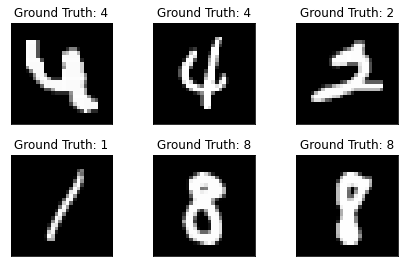

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(data[i][0], cmap = 'gray', interpolation = 'none')
    plt.title("Ground Truth: {}".format(targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size = 5)
        self.conv2 = nn.Conv2d(10,20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)

In [10]:
grad_value = []
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epoch + 1)]

In [11]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch : {} [{}/{} ({:.0f}%)] \tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(batch_idx*len(data) + (epoch-1)*len(train_loader.dataset))
            grad_value.append(grad_flow(network.named_parameters()))

In [12]:
def grad_flow(named_parameters):
    sum_g = 0
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            sum_g = sum_g + p.grad.norm().item()
    return sum_g

In [13]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [14]:
test()
for epoch in range(1, n_epoch + 1):
    train(epoch)
    test()

/home/shashank/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/shashank/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)

Train Epoch : 1 [0/60000 (0%)] 	Loss: 2.368649


/home/shashank/anaconda3/envs/torch/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Train Epoch : 1 [640/60000 (1%)] 	Loss: 2.298366
Train Epoch : 1 [1280/60000 (2%)] 	Loss: 2.294433
Train Epoch : 1 [1920/60000 (3%)] 	Loss: 2.260970
Train Epoch : 1 [2560/60000 (4%)] 	Loss: 2.295450
Train Epoch : 1 [3200/60000 (5%)] 	Loss: 2.239505
Train Epoch : 1 [3840/60000 (6%)] 	Loss: 2.274136
Train Epoch : 1 [4480/60000 (7%)] 	Loss: 2.225711
Train Epoch : 1 [5120/60000 (9%)] 	Loss: 2.168033
Train Epoch : 1 [5760/60000 (10%)] 	Loss: 2.138118
Train Epoch : 1 [6400/60000 (11%)] 	Loss: 2.061368
Train Epoch : 1 [7040/60000 (12%)] 	Loss: 1.945130
Train Epoch : 1 [7680/60000 (13%)] 	Loss: 1.949193
Train Epoch : 1 [8320/60000 (14%)] 	Loss: 1.750880
Train Epoch : 1 [8960/60000 (15%)] 	Loss: 1.642634
Train Epoch : 1 [9600/60000 (16%)] 	Loss: 1.585531
Train Epoch : 1 [10240/60000 (17%)] 	Loss: 1.416778
Train Epoch : 1 [10880/60000 (18%)] 	Loss: 1.314596
Train Epoch : 1 [11520/60000 (19%)] 	Loss: 1.256788
Train Epoch : 1 [12160/60000 (20%)] 	Loss: 1.344633
Train Epoch : 1 [12800/60000 (21%)] 

Train Epoch : 2 [41600/60000 (69%)] 	Loss: 0.191254
Train Epoch : 2 [42240/60000 (70%)] 	Loss: 0.213719
Train Epoch : 2 [42880/60000 (71%)] 	Loss: 0.417919
Train Epoch : 2 [43520/60000 (72%)] 	Loss: 0.516177
Train Epoch : 2 [44160/60000 (74%)] 	Loss: 0.534748
Train Epoch : 2 [44800/60000 (75%)] 	Loss: 0.250047
Train Epoch : 2 [45440/60000 (76%)] 	Loss: 0.427577
Train Epoch : 2 [46080/60000 (77%)] 	Loss: 0.339915
Train Epoch : 2 [46720/60000 (78%)] 	Loss: 0.397955
Train Epoch : 2 [47360/60000 (79%)] 	Loss: 0.332257
Train Epoch : 2 [48000/60000 (80%)] 	Loss: 0.313488
Train Epoch : 2 [48640/60000 (81%)] 	Loss: 0.282826
Train Epoch : 2 [49280/60000 (82%)] 	Loss: 0.344121
Train Epoch : 2 [49920/60000 (83%)] 	Loss: 0.154136
Train Epoch : 2 [50560/60000 (84%)] 	Loss: 0.343768
Train Epoch : 2 [51200/60000 (85%)] 	Loss: 0.273400
Train Epoch : 2 [51840/60000 (86%)] 	Loss: 0.328650
Train Epoch : 2 [52480/60000 (87%)] 	Loss: 0.214224
Train Epoch : 2 [53120/60000 (88%)] 	Loss: 0.609043
Train Epoch 

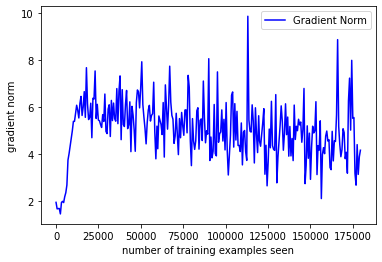

In [31]:
fig = plt.figure()
plt.plot(train_counter, grad_value, color='blue')
plt.legend(['Gradient Norm'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('gradient norm')
plt.show()